# **Imports**

In [ ]:
# Common
import os
import cv2 as cv
from keras.metrics import MeanIoU
from tqdm import tqdm

# data
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt

# Model
import keras
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

In [ ]:
def show_image(image, cmap=None, title=None):
  plt.imshow(image, cmap=cmap)
  if title is not None: plt.title(title)
  plt.axis('off')


In [ ]:
images = []
mask = []

image_path = './Merged Dataset/Images/'
mask_path = './Merged Dataset/Masks/'

image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

if image_names == mask_names:
  print('Image and Mask are corretly Placed!!')

Image and Mask are corretly Placed!!


In [ ]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = img_to_array(load_img(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = img_to_array(load_img(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:36<00:00, 76.85it/s] 


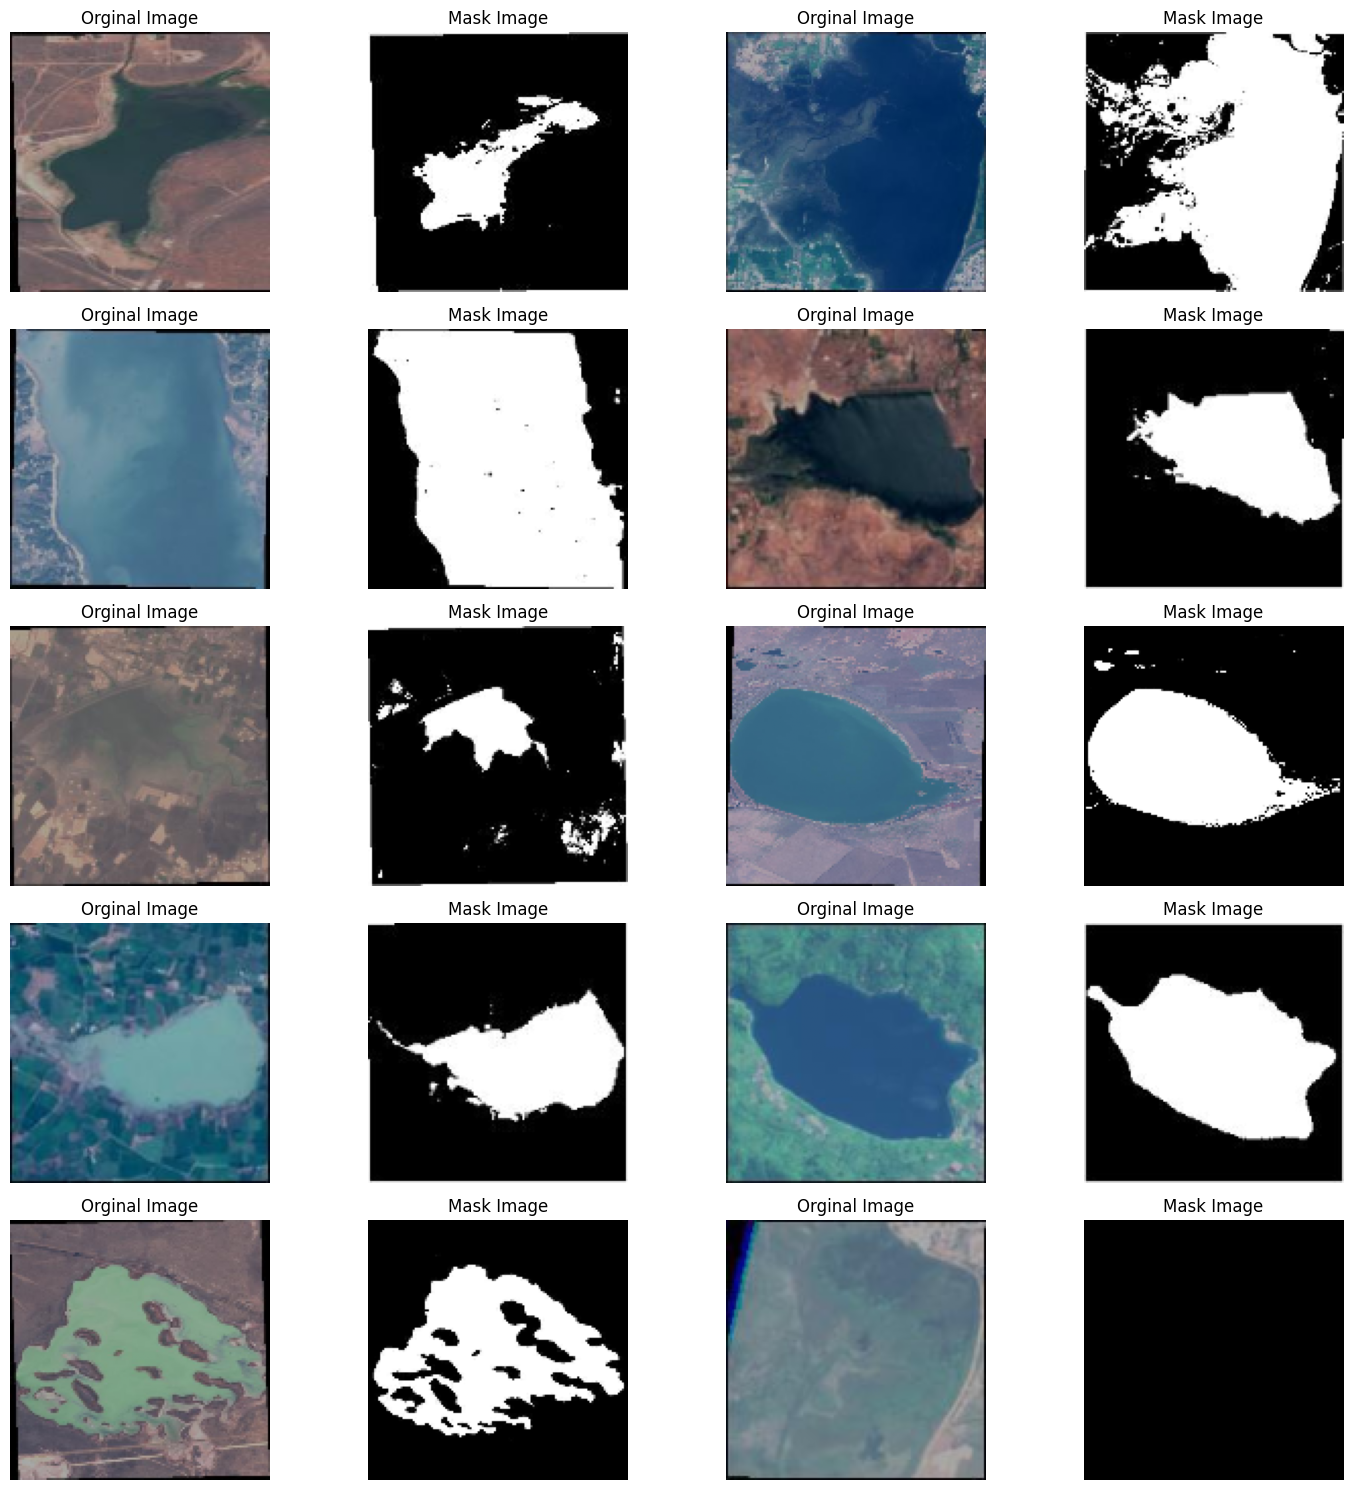

In [ ]:
plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

# **U-Net**

In [ ]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

In [ ]:
# Contraction
class EncoderBlock(keras.layers.Layer):

  def __init__(self, filters, rate=None, pooling=True):
    super(EncoderBlock,self).__init__()
    self.filters = filters
    self.rate = rate
    self.pooling = pooling
    self.conv1 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
    self.conv2 = Conv2D(self.filters,kernel_size=3,strides=1,padding='same',activation='relu',kernel_initializer='he_normal')
    if self.pooling: self.pool = MaxPool2D(pool_size=(2,2))
    if self.rate is not None: self.drop = Dropout(rate)

  def call(self, inputs):
    x = self.conv1(inputs)
    if self.rate is not None: x = self.drop(x)
    x = self.conv2(x)
    if self.pooling:
      y = self.pool(x)
      return y, x
    else:
      return x

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        "rate":self.rate,
        "pooling":self.pooling
    }

# Expansion
class DecoderBlock(keras.layers.Layer):

  def __init__(self, filters, rate=None, axis=-1):
    super(DecoderBlock,self).__init__()
    self.filters = filters
    self.rate = rate
    self.axis = axis
    self.convT = Conv2DTranspose(self.filters,kernel_size=3,strides=2,padding='same')
    self.conv1 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')
    if rate is not None: self.drop = Dropout(self.rate)
    self.conv2 = Conv2D(self.filters, kernel_size=3, activation='relu', kernel_initializer='he_normal', padding='same')

  def call(self, inputs):
    X, short_X = inputs
    ct = self.convT(X)
    c_ = concatenate([ct, short_X], axis=self.axis)
    x = self.conv1(c_)
    if self.rate is not None: x = self.drop(x)
    y = self.conv2(x)
    return y

  def get_config(self):
    base_config = super().get_config()
    return {
        **base_config,
        "filters":self.filters,
        "rate":self.rate,
        "axis":self.axis,
    }

# Callback
class ShowProgress(keras.callbacks.Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask)
    proc_mask2 = post_process(pred_mask, threshold=0.5)
    proc_mask3 = post_process(pred_mask, threshold=0.9)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(10,5))

    plt.subplot(1,6,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,6,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')

    plt.subplot(1,6,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,6,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,6,5)
    show_image(proc_mask2, title="Processed@0.5", cmap='gray')

    plt.subplot(1,6,6)
    show_image(proc_mask3, title="Processed@0.9", cmap='gray')

    plt.tight_layout()
    if self.save: plt.savefig("Progress-{}.png".format(epoch+1))
    plt.show()

# Post Process
def post_process(image,threshold=0.4):
  return image>threshold


In [ ]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4)

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

In [ ]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('UNet-01.keras',save_best_only=True),
    ShowProgress(save=True)
]

When I train models that actually produce images, I mostly trust my own eyes than trusting the matrics.

In [ ]:
unet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_15    │ [(None, 64, 64,   │      2,768 │ input_layer_3[0]… │
│ (EncoderBlock)      │ 16), (None, 128,  │            │                   │
│                     │ 128, 16)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_16    │ [(None, 32, 32,   │     13,888 │ encoder_block_15… │
│ (EncoderBlock)      │ 32), (None, 64,   │            │                   │
│                     │ 64, 32)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_17    │ [(None, 16, 16,   │     55,424 │ encoder_block_16… │
│ (EncoderBlock)      │ 64), (None, 32,   │            │                   │
│                     │ 32, 64)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_18    │ [(None, 8, 8,     │    221,440 │ encoder_block_17… │
│ (EncoderBlock)      │ 128), (None, 16,  │            │                   │
│                     │ 16, 128)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_block_19    │ (None, 8, 8, 256) │    885,248 │ encoder_block_18… │
│ (EncoderBlock)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block_12    │ (None, 16, 16,    │    737,664 │ encoder_block_19… │
│ (DecoderBlock)      │ 128)              │            │ encoder_block_18… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block_13    │ (None, 32, 32,    │    184,512 │ decoder_block_12… │
│ (DecoderBlock)      │ 64)               │            │ encoder_block_17… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block_14    │ (None, 64, 64,    │     46,176 │ decoder_block_13… │
│ (DecoderBlock)      │ 32)               │            │ encoder_block_16… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_block_15    │ (None, 128, 128,  │     11,568 │ decoder_block_14… │
│ (DecoderBlock)      │ 16)               │            │ encoder_block_15… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_75 (Conv2D)  │ (None, 128, 128,  │         17 │ decoder_block_15… │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


e:\ThesisB10\thesisb10\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_84']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5836 - loss: 0.5743

e:\ThesisB10\thesisb10\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_84']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


e:\ThesisB10\thesisb10\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_84']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


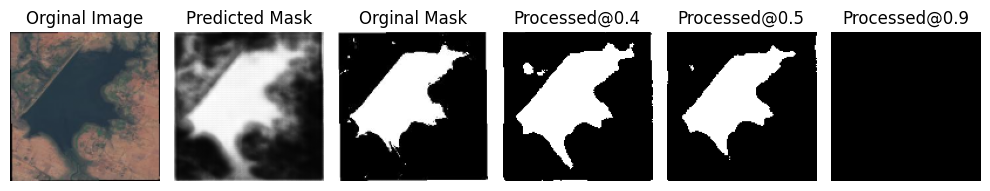

144/144 ━━━━━━━━━━━━━━━━━━━━ 22s 132ms/step - accuracy: 0.5838 - loss: 0.5741 - val_accuracy: 0.6065 - val_loss: 0.4958
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step/step - accuracy: 0.6245 - loss: 0.492


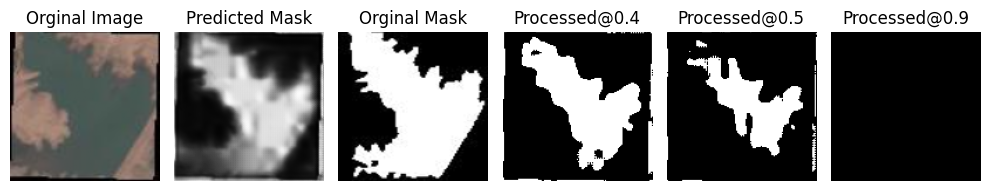

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - accuracy: 0.6246 - loss: 0.4926 - val_accuracy: 0.6775 - val_loss: 0.3930
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step/step - accuracy: 0.6664 - loss: 0.431


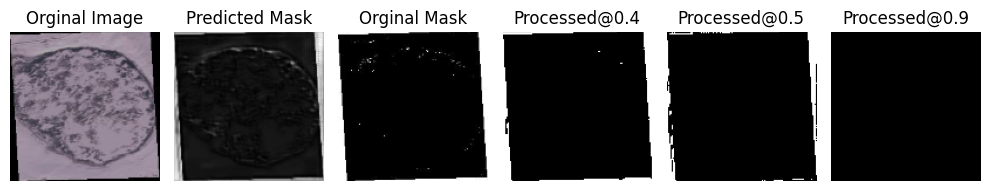

144/144 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.6664 - loss: 0.4313 - val_accuracy: 0.6753 - val_loss: 0.3899
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step/step - accuracy: 0.6701 - loss: 0.418


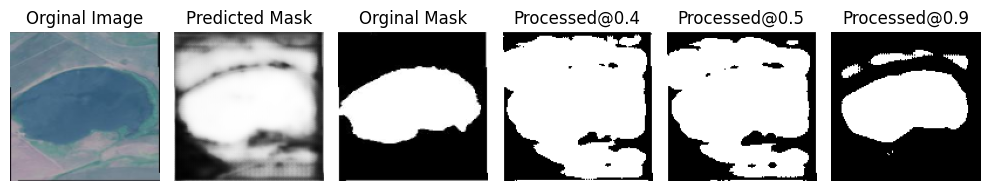

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.6701 - loss: 0.4182 - val_accuracy: 0.7008 - val_loss: 0.3384
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step/step - accuracy: 0.6882 - loss: 0.391


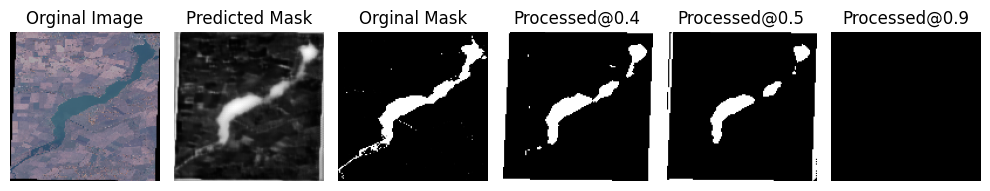

144/144 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.6881 - loss: 0.3915 - val_accuracy: 0.7033 - val_loss: 0.3474
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step/step - accuracy: 0.6776 - loss: 0.398


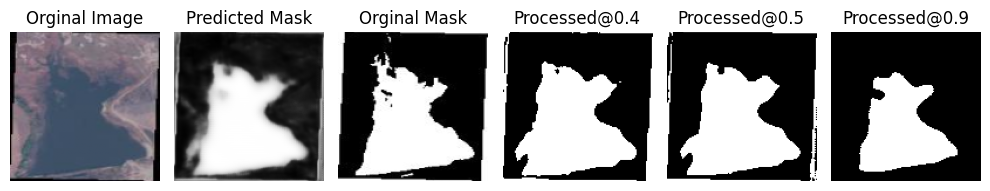

144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.6776 - loss: 0.3985 - val_accuracy: 0.6694 - val_loss: 0.4073
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step/step - accuracy: 0.6836 - loss: 0.388


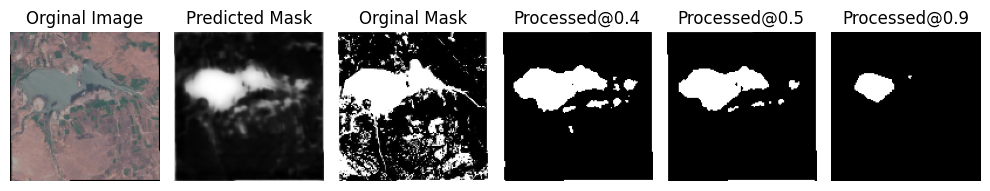

144/144 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.6836 - loss: 0.3884 - val_accuracy: 0.6913 - val_loss: 0.3496
CPU times: total: 1min 51s
Wall time: 2min 29s


In [ ]:
%%time
with tf.device("/GPU:0"):
  results = unet.fit(
      X, y,
      epochs=100,
      callbacks=callbacks,
      validation_split=0.1,
      batch_size=16
  )

* After looking at the produced images, it could be said that the model is actually able to identify the regions of water but its confused between water and forest when the color difference between them is low.

* It could also be noticed that the model is actually preserving some of these spatial features which we actually don't want in the final image. That's why I have post processed it.

* Overall, the model is great. It's actually able to identify the regions correctly. Well, not exactly up to the point, but roughly correct enough to be convincing.

# **Adaptive Threshold UNET**

In [ ]:
# Callback
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask, threshold=0.5)
    thresh = float(np.mean(pred_mask) + np.min(pred_mask))
    proc_mask2 = post_process(pred_mask, threshold=thresh)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(15,6))

    plt.subplot(1,5,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,5,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')

    plt.subplot(1,5,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,5,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,5,5)
    show_image(proc_mask2, title="Processed@{:.2}".format(thresh), cmap='gray')

    plt.tight_layout()
    plt.show()

# Post Process
def post_process(image,threshold): return image>threshold

In [ ]:
inputs= Input(shape=(SIZE,SIZE,3))

# Contraction
p1, c1 = EncoderBlock(16,0.1)(inputs)
p2, c2 = EncoderBlock(32,0.1)(p1)
p3, c3 = EncoderBlock(64,0.2)(p2)
p4, c4 = EncoderBlock(128,0.2)(p3)

# Encoding Layer
c5 = EncoderBlock(256,rate=0.3,pooling=False)(p4)

# Expansion
d1 = DecoderBlock(128,0.2)([c5,c4]) # [current_input, skip_connection]
d2 = DecoderBlock(64,0.2)([d1,c3])
d3 = DecoderBlock(32,0.1)([d2,c2])
d4 = DecoderBlock(16,0.1, axis=3)([d3,c1])

# Outputs
outputs = Conv2D(1,1,activation='sigmoid')(d4)

unet = keras.models.Model(
    inputs=[inputs],
    outputs=[outputs],
)

In [ ]:
unet.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [ ]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('Adaptive-UNet.keras',save_best_only=True),
    ShowProgress()
]

I saved the model with a different name even though the model doesn't learn anything new, but I thought let's keep them separated.

Epoch 1/100


e:\ThesisB10\thesisb10\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_112']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5406 - loss: 0.5947

e:\ThesisB10\thesisb10\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_112']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


e:\ThesisB10\thesisb10\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_112']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


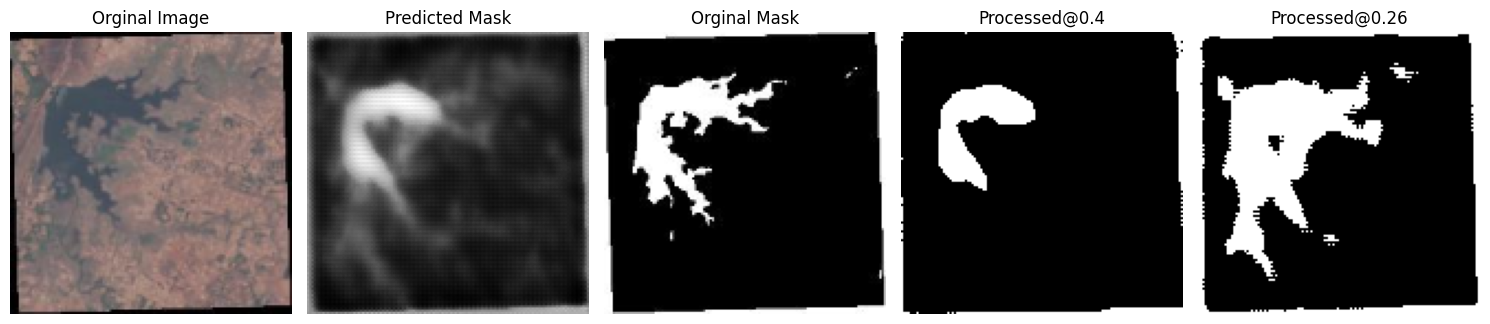

72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 306ms/step - accuracy: 0.5412 - loss: 0.5941 - val_accuracy: 0.6039 - val_loss: 0.4984
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/steptep - accuracy: 0.6443 - loss: 0.476


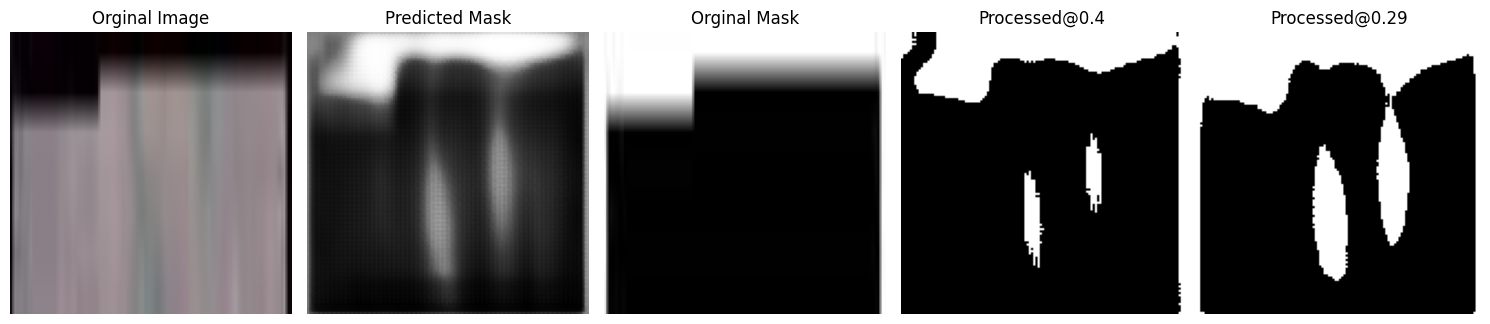

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - accuracy: 0.6443 - loss: 0.4764 - val_accuracy: 0.6404 - val_loss: 0.4278
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/steptep - accuracy: 0.6476 - loss: 0.461


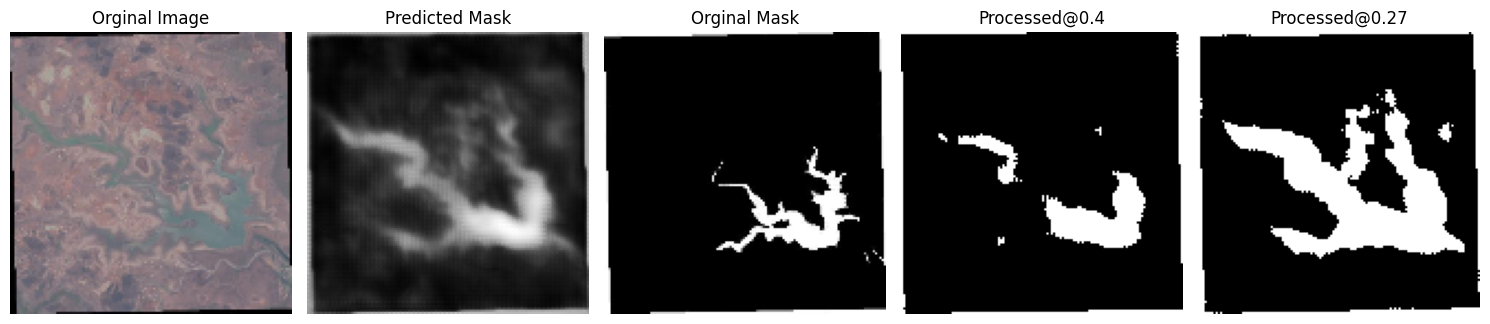

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - accuracy: 0.6478 - loss: 0.4614 - val_accuracy: 0.6382 - val_loss: 0.4406
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/steptep - accuracy: 0.6697 - loss: 0.416


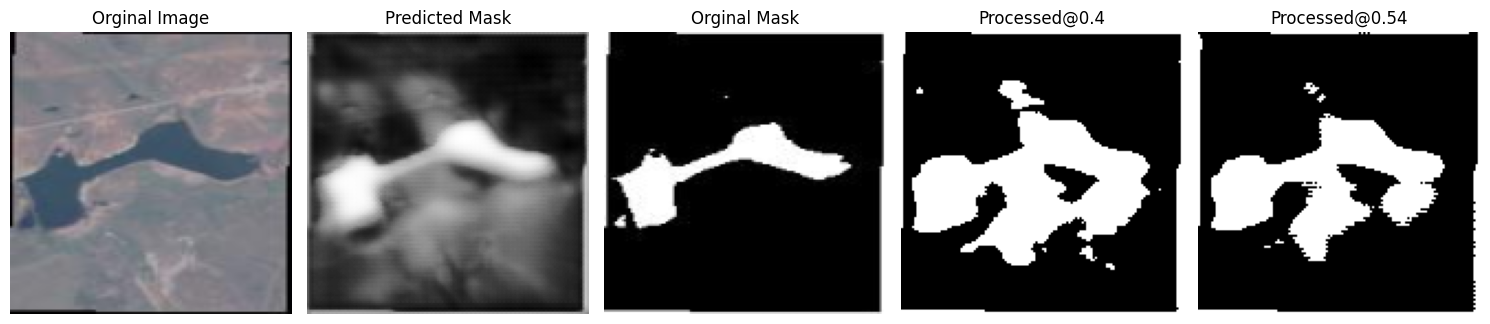

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 303ms/step - accuracy: 0.6698 - loss: 0.4165 - val_accuracy: 0.6425 - val_loss: 0.4455
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/steptep - accuracy: 0.6844 - loss: 0.405


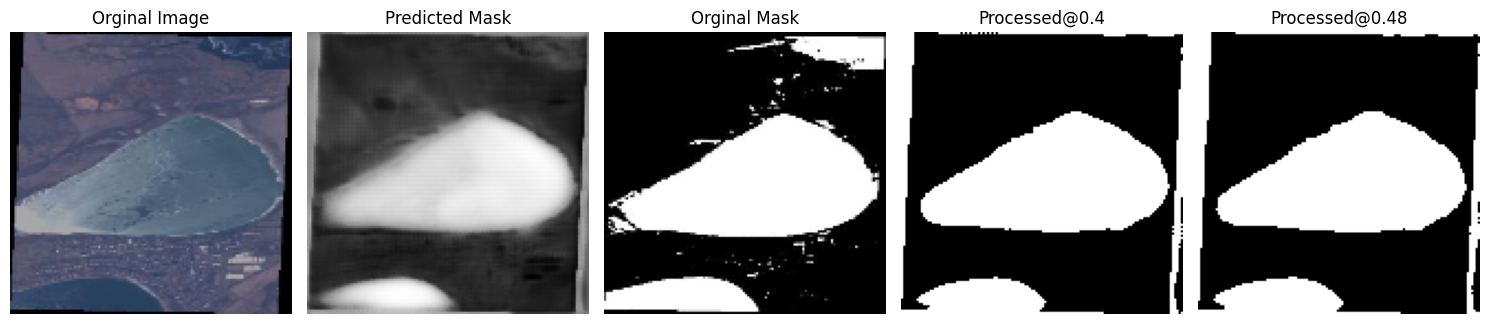

72/72 ━━━━━━━━━━━━━━━━━━━━ 22s 302ms/step - accuracy: 0.6843 - loss: 0.4059 - val_accuracy: 0.6399 - val_loss: 0.4443
CPU times: total: 1min 19s
Wall time: 1min 52s


In [ ]:
%%time
with tf.device("/GPU:0"):
  results = unet.fit(
      X, y,
      epochs=100,
      callbacks=callbacks,
      validation_split=0.1,
      batch_size=32
  )

You can decide what type of threshold you're willing to use. I kind of like loved the idea of using the adaptive threshold. Now, if you somehow find the best threshold value, then you can actually get the best masking, because the model is able to predict the mask correctly almost 99% of the time, but some of the regions are blurry and somehow, you will have to tackle them. My technique was to add this Adaptive Threshold your technique could be something else.

# **Testing**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


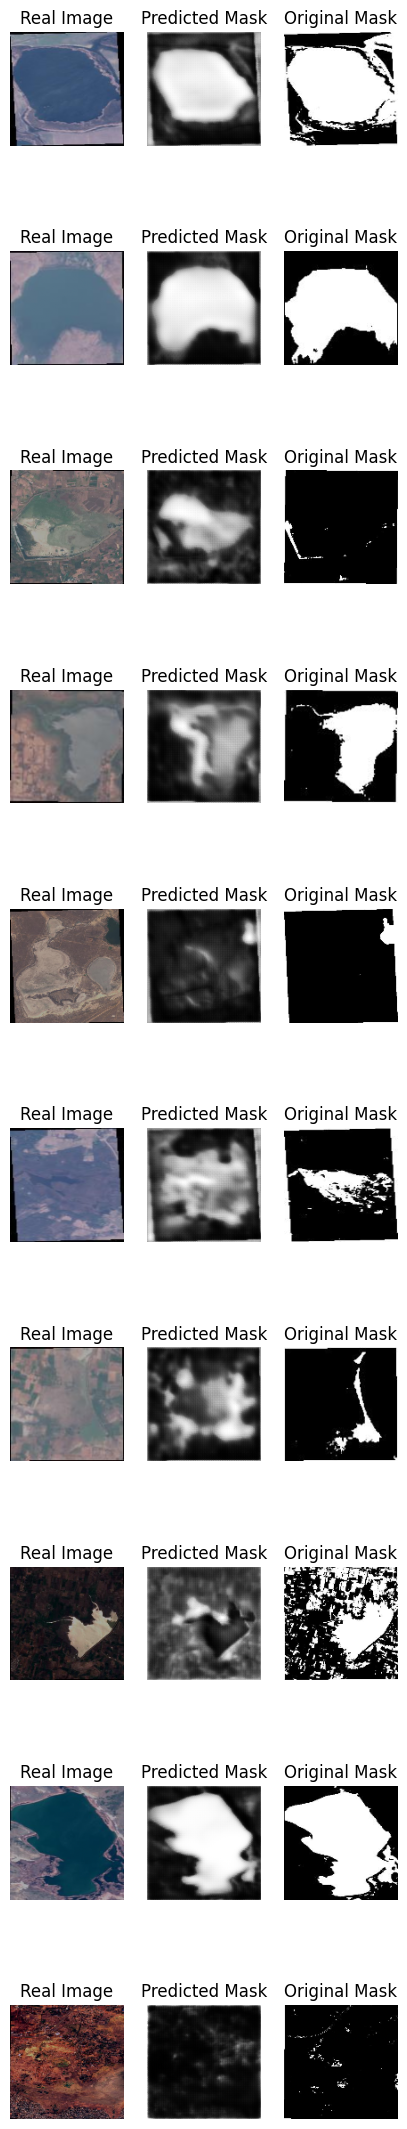

In [ ]:
plt.figure(figsize=(5,28))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)

    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = unet.predict(real_img).reshape(128,128)
        mask = masks[id].reshape(128,128)
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask", cmap='gray')
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask", cmap='gray')
        n=0

The **high clarity** that you are able to find in the **original mask** is probably because they have used a **threshold** and that makes it **highly clear**. But as our model is **producing that image**, it's pretty good that it's able to **produce images with mask**, even if they are a **little bit of blurry**.

---
Thanks!!! and if you have any suggestions, please let me know.

In [ ]:
meanIoU = MeanIoU(num_classes=2)
for image, mask in zip(test_X, test_y):
    pred_mask = unet.predict(image[np.newaxis,...])
    meanIoU.update_state(mask, pred_mask)
print(meanIoU.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

This **low meanIoU score** is because of the **high clarity** of the **original mask images**, where the **produced images** are **very blurry** and their **edges are not sharp**.